<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Инструкция-по-выполнению-проекта" data-toc-modified-id="Инструкция-по-выполнению-проекта-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Инструкция по выполнению проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Подготовка-данных-и-обучение-модели" data-toc-modified-id="Подготовка-данных-и-обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных и обучение модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

нужно постройть модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

### Инструкция по выполнению проекта
- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.
- Вашей метрикой качества будет MAE.
- Итоговое МАЕ должно быть не более 8.

### Описание данных
Данные взяты с сайта `ChaLearn Looking at People`. Они находятся в папке `/datasets/faces/`.

В нашем распоряжении одна папка со всеми изображениями (`/final_files`) и csv-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим и посмотрим на данные

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
def feature_analiser(data, title, x_label):
    """ Функция принимает колонку, заголовок и подпись оси Х
        Выводит на экран гистограмму распределения и диаграму размаха
    """
    fig = plt.figure(figsize=(15,11))
    # Вывод гистограмы
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_1 = sns.histplot(data=data, bins=100)
    ax_1.axes.set_title(title, fontsize=16)
    ax_1.set_xlabel(x_label, fontsize=14)
    
    # Вывод диаграмы размаха
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_2 = sns.boxplot(data=data, orient='h')
    ax_2.axes.set_title(title, fontsize=16)
    ax_2.set_xlabel(x_label, fontsize=14)

    plt.show();

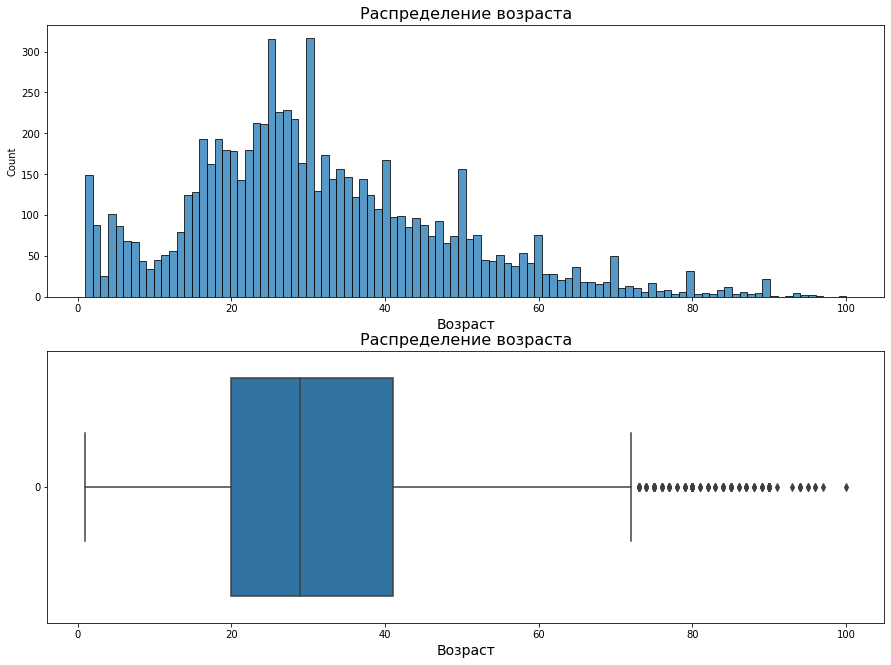

In [8]:
feature_analiser(df['real_age'], 'Распределение возраста', 'Возраст')

Данные в файле `labels.csv` представленны ввиде двух столбцов: имени файла с фотографией человека и его возрастом. Типы столбцов соответствуют содержимому. Пропусков в данных нет, дубликатов тоже нет.

Распеделение возраста похоже на опись населения какого-то современного населеного пункта при демографическом исследовании. Стариков не много, но есть долгожители; детей более чем в три раза меньше активного взрослого населения. 

Возраст распеределен не равномерно. Очень мало фотографий после 60 лет. А после 70 на диаграме размаха выглядит как выброс. Странный минимум в районе 3  и 9 лет. 

Основная масса фото в диапазоне от 20 до 42 лет. Среднее и медиана близки: 31 год и 29 лет соответсвенно. Минимум 1 год, максимум 100 лет. После 25 лет наблюдаются пики соответствующие круглым датам в 30, 40, 50 и до 90 лет включительно. В выборке отсутствуют фото людей 92, 98 и 99 лет.

Для обучения модели определения возраста идеально было бы иметь одинаковое количество фото разных людей каждого возраста. И количество фото для каждого возраста желательно иметь более одной сотни, порядка тысячи. Но у нас всего 7591 фото.

Посмотрим на сами фотографии. 

Извлечем фото с помощью метода *ImageDataGenerator* — `flow_from_dataframe(dataframe, directory, ...)`

In [9]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Обнаруженное количество файлов с фотографиями с указанием возраста соответствует количеству строк: 7591.



In [10]:
features, target = next(train_gen_flow)
print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


В первом батче видим 32 картинки размером *224*224* пикселя, и каждый пиксель состоит из 3 значений: красный, зелёный, синий. И соответствующее количество значений с возрастом в *target*.


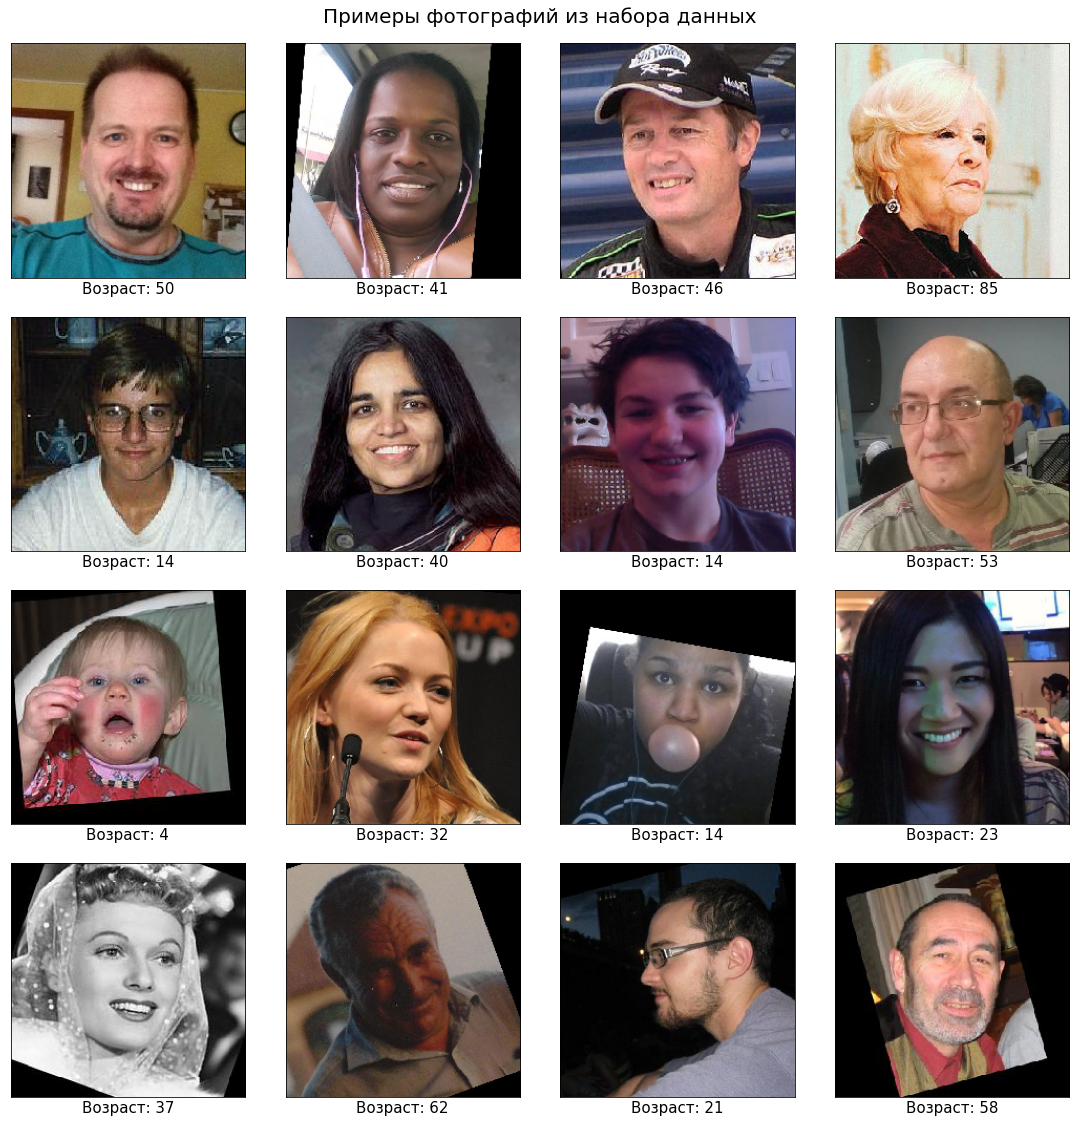

In [11]:
# выводим 16 изображений
fig = plt.figure(figsize=(16,16))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(f'Возраст: {target[i]}', fontsize = 15)
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.suptitle('Примеры фотографий из набора данных', fontsize = 20)
plt.tight_layout(pad=2)
plt.show()
plt.close()

На фото представлены портреты в различной обстановке. Портреты не только в фас и профиль, но под другими естественными углами поворота головы. На некоторых фото лица представлены не вертикально. Встречаются черно-белые фото. Люди разных рас. На некоторых фото часть головы обрезана или загорожена предметом.

Такими образом, у нас недостаточное количество материала. Чтоб увеличить количество фото для каждого возраста и учесть возможное расположение лица на фото при моделирование применим аугментацию.

**Вывод**

1. Набор данных содержит 7591 фотографию. Данного количества может не хватить для обучения нейросети. Для увеличения выборки, на этапе предобработки применим добавление аугментаций.
2. Пропусков и дубликатов в данных нет.
3. Анализ возраста в датасете:
    - Диапазон возрастов от 1 до 100 лет.
    - Средний возраст 31 год, медианный 29.
    - Большая часть возрастов людей на представленных фотографиях лежит в диапозоне от 20 до 40 лет.
    - Люди старшего возраста в наборе данных представленны достаточно слабо: по 1-5 фотографий.  Данный факт может стать фактором, ухудшающим качество будущей модели. Частичному решению данной проблемы, также послужит добавление аугментаций.
    - На гистограмме наблюдаются пики в районе круглых десятков лет. Это может быть связано с тем, что в юбилей делалось больше фоторгафий. Это не должно сильно повлиять на работу модели.
4. Анализ фотографий:
    - Портрет на полученных фотографиях занимают разную долю фотогрвфии. И на некоторых фотографиях лица людей занимают лишь малую часть фотографии. В качестве фона попадает различная мебель, на которых модель, к сожалению, тоже будет обучаться. 
    - Большинство фотографий предобработаны. В них изменён угол поворота и произведена обрезка по размеру лица. Это положительно повлияет на качество обучения модели. 
    - Также, встречаются фотографии, где в кадр попадают другие люди, что может негативно сказаться на качестве модели.

## Подготовка данных и обучение модели

Для обучения модели в тренажёре ЯндексПрактикума на GPU, создадим необходимые функции:
1. `load_train`. Функция будет возвращать загрузчик тренировачного набора даннных. В данном загрузчике изображения будут приводится к одному размеру. Также, для увеличения тренировочной выборки и частичного решения проблемы наличия малого количества фотографий людей старшего возраста, добавим аугментации в тренировочные данные. Применим смещения и поворот по горизонтали. Отложим 25% под тестовую выборку.
2. `load_test`. Функция будет возвращать загрузчик трестового набора даннных. В данном загрузчике изображения будут приводится к одному размеру. Аугментации в тестовые данные добавлять не будем.
3. `create_model`. Функция будет возвращать модель. Создание нейросетевой модели с нуля не целесообразно, поэтому создавать модель будем на основе существующих архитектур. Для построения модели будем использовать модель с архитектурой `ResNet50` из библиотеки Keras. Вместо последних двух слоёв `ResNet50` добавим слои в двех вариантах:
 - Первый вариант *Pooling2D-Dense-1*:
    - GlobalAveragePooling2D - для усреднения информации по всему изображению на выходе из ResNet50;
    - Dense(1, activation='relu') - выходной слой, выдающий значение прогнозируемого возраста.
 - Второй вариант *Pooling2D-Dense-64-1*:
    - GlobalAveragePooling2D - для усреднения информации по всему изображению на выходе из ResNet50;
    - Dense(64, activation='relu') - для снижения размерности признаков;
    - Dense(1, activation='relu') - выходной слой, выдающий значение прогнозируемого возраста.

    
    Компиляцию модели осуществим со следующими параметрами:
    - Оптимизатор `Adam` или `Adamax`, а также его параметр `learning_rate` подоберём опытным путём;
    - Функцию потерь `MSE`;
    - Метрику качества `MAE`
4. `train_model`. Функция будет обучать модель и возвращать модель после обучения. Оптимальное количество эпох обучения, подберём опытным путём.

Ниже представлен код для лучшей модели.

```python
# Импортируем необходимые объекты и модули
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense #, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax #Adam

# Общие параметры для загрузчиков удобно соберём в словари -
# после распакуем их внутри функций
datagen_kws = {'validation_split': 0.25,
               'rescale': 1./255}

flow_kws = {#'dataframe': labels, #labels определяется внутри функций
            'x_col': 'file_name',
            'y_col': 'real_age',
            'target_size': (224, 224),
            'batch_size': 32,
            'class_mode': 'raw',
            'seed': 12345}

# Создание загрузчика для обучающей выборки с отражением фотографий по горизонтали и смещением
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       **datagen_kws)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
                            dataframe=labels,
                            directory=path + 'final_files/',
                            subset='training',
                            **flow_kws)
    #print('train shape =', len(train_datagen_flow.filenames))
    return train_gen_flow

# Создание загрузчика для тестовой выборки
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(**datagen_kws)
    test_gen_flow = test_datagen.flow_from_dataframe(
                            dataframe=labels,
                            directory=path + 'final_files/',
                            subset='validation',
                            **flow_kws)
    #print('test shape =', len(test_datagen_flow.filenames))
    return test_gen_flow
    

# Создание модели
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
     
    optimizer = Adamax(lr=0.0003)

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    #model.summary()
    return model

# Параметры обучения
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True
             )

    return model
```

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 118s - loss: 193.3532 - mae: 10.1915 - val_loss: 615.5030 - val_mae: 19.8199
Epoch 2/15
178/178 - 89s - loss: 83.9092 - mae: 6.9781 - val_loss: 511.0978 - val_mae: 17.5375
Epoch 3/15
178/178 - 89s - loss: 61.2879 - mae: 5.9778 - val_loss: 277.6349 - val_mae: 12.2659
Epoch 4/15
178/178 - 89s - loss: 50.8299 - mae: 5.4600 - val_loss: 109.7573 - val_mae: 7.8228
Epoch 5/15
178/178 - 89s - loss: 41.6464 - mae: 4.9718 - val_loss: 93.6273 - val_mae: 7.4094
Epoch 6/15
178/178 - 89s - loss: 36.1055 - mae: 4.6369 - val_loss: 85.8401 - val_mae: 7.0084
Epoch 7/15
178/178 - 89s - loss: 32.4061 - mae: 4.3993 - val_loss: 69.0138 - val_mae: 6.0076
Epoch 8/15
178/178 - 89s - loss: 28.4594 - mae: 4.0817 - val_loss: 86.9372 - val_mae: 7.2079
Epoch 9/15
178/178 - 90s - loss: 27.0355 - mae: 4.0107 - val_loss: 85.0035 - val_mae: 6.9877
Epoch 10/15
178/178 - 90s - loss: 24.0142 - mae: 3.7945 - val_loss: 72.6270 - val_mae: 6.3935
Epoch 11/15
178/178 - 89s - loss: 21.1634 - mae: 3.5437 - val_loss: 79.6316 - val_mae: 6.4437
Epoch 12/15
178/178 - 89s - loss: 18.2217 - mae: 3.2960 - val_loss: 66.8431 - val_mae: 5.9101
Epoch 13/15
178/178 - 89s - loss: 17.8049 - mae: 3.2323 - val_loss: 63.7202 - val_mae: 5.8097
Epoch 14/15
178/178 - 89s - loss: 16.2457 - mae: 3.1165 - val_loss: 67.9063 - val_mae: 6.0624
Epoch 15/15
178/178 - 89s - loss: 15.3477 - mae: 3.0131 - val_loss: 62.5743 - val_mae: 5.8950
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.5743 - mae: 5.8950
Test MAE: 5.8950
```

В таблице представлены итоговые результаты обучения некоторых из расмотренных моделей:


| Модель |     Последние слои     | Оптимизатор |  learning_rate | Количество эпох | MAE | Обозначение модели        |
| :----- | :----------------------| :-----------| :------------- |:----------------|:--- | :------------------------ |
| ResNet50 | Pooling2D-Dense-1 | Adam | 0.001 | 15 | 8.5374 | '0-1_lr001' |
| ResNet50 | Pooling2D-Dense-1 | Adam | 0.0005 | 15 | 8.6283 | '0-1_lr0005' |
| ResNet50 | Pooling2D-Dense-1 | Adam | 0.0003 | 15 | 7.0437 | '0-1_lr0003' |
| ResNet50 | Pooling2D-Dense-64-1 | Adam | 0.0005 | 15 | 6.5757 | '64-1_lr0005' |
| ResNet50 | Pooling2D-Dense-64-1 | Adam | 0.0003 | 15 | 6.9720 | '64-1_lr0003' |
| ResNet50 | Pooling2D-Dense-64-1 | Adamax | 0.0003 | 15 | 5.8950 | '64-1_lr0003_Adamax' | 
| ResNet50 | Pooling2D-Dense-64-1 | Adamax | 0.0002 | 15 | 6.4082 | '64-1_lr0002_Adamax' |


В таблице представленно итоговое MAE на тестовой выборке. 

Лучший результат 5.8950 у модели *64-1_lr0003_Adamax* с оптимизатором Adamax, слоем снижения размерности признаков и скоростью обучения 0.0003.

Чтоб оценить модели, посмотрим на изменение MAE для тестовой выборки по эпохам во время обучения. Для этого сведем эти МАЕ в таблицу и построим график.

In [4]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
data_mae = {
    '0-1_lr001':          [12.95, 13.29, 12.91, 12.98, 10.38, 14.75, 10.14,  9.74,  8.95, 11.38,  8.75,  8.68,  8.34, 14.56,  8.54], # _0-1_lr001_ep15
    '0-1_lr0005':         [14.01, 13.26, 15.24, 13.20,  8.44,  8.12, 10.04,  7.40,  8.98,  9.13,  9.35,  8.92,  6.91,  7.82,  8.62], # _0-1_lr0005_ep15
    '0-1_lr0003':         [20.75, 14.74, 16.55, 10.39,  7.79,  9.83,  8.08,  6.88,  6.96,  7.17,  7.25,  8.67,  6.70,  9.54,  7.04], # _0-1_lr0003_ep15
    '64-1_lr0005':        [14.26, 12.82, 13.10, 12.23,  8.52,  8.29,  9.94,  8.97,  9.63,  8.37,  8.17,  6.70,  7.19,  8.03,  6.58], # _64-1_lr0005_ep15
    '64-1_lr0003':        [16.56, 14.01, 12.13,  9.38,  7.85,  6.84,  9.97,  7.97,  6.33,  6.69,  6.79,  6.29,  7.57,  6.52,  6.97], # _64-1_lr0003_ep15
    '64-1_lr0003_Adamax': [19.82, 17.54, 12.27,  7.82,  7.41,  7.01,  6.01,  7.21,  6.99,  6.39,  6.44,  5.91,  5.81,  6.06,  5.90], # _64-1_lr0003_ep15_Admx
    '64-1_lr0002_Adamax': [24.28, 23.55, 15.64,  8.84,  7.61,  6.58,  6.52,  6.54,  7.61,  7.71,  7.42,  6.52,  6.35,  6.38,  6.41], # _64-1_lr0002_ep15_Admx
} 

df_mae = pd.DataFrame(data=data_mae, index=epochs)

In [5]:
def data_plot(data, name):
    data.plot(linewidth=5, figsize=(17, 15))   
    plt.xlabel('Epoch', fontsize = 15) 
    plt.ylabel('MAE', fontsize = 15) 
    plt.xticks(rotation = 0, fontsize = 15)
    plt.yticks(rotation = 0, fontsize = 15)
    plt.grid(True) 
    plt.title(name, fontsize = 20)
    plt.legend(loc='right', #loc='upper right',
               fontsize = 15,
               ncol = 2,    #  количество столбцов
               facecolor = 'oldlace',    #  цвет области
               edgecolor = 'r',    #  цвет крайней линии
               title = 'Модели',    #  заголовок
               title_fontsize = '20'    #  размер шрифта заголовка
              )
    plt.show();

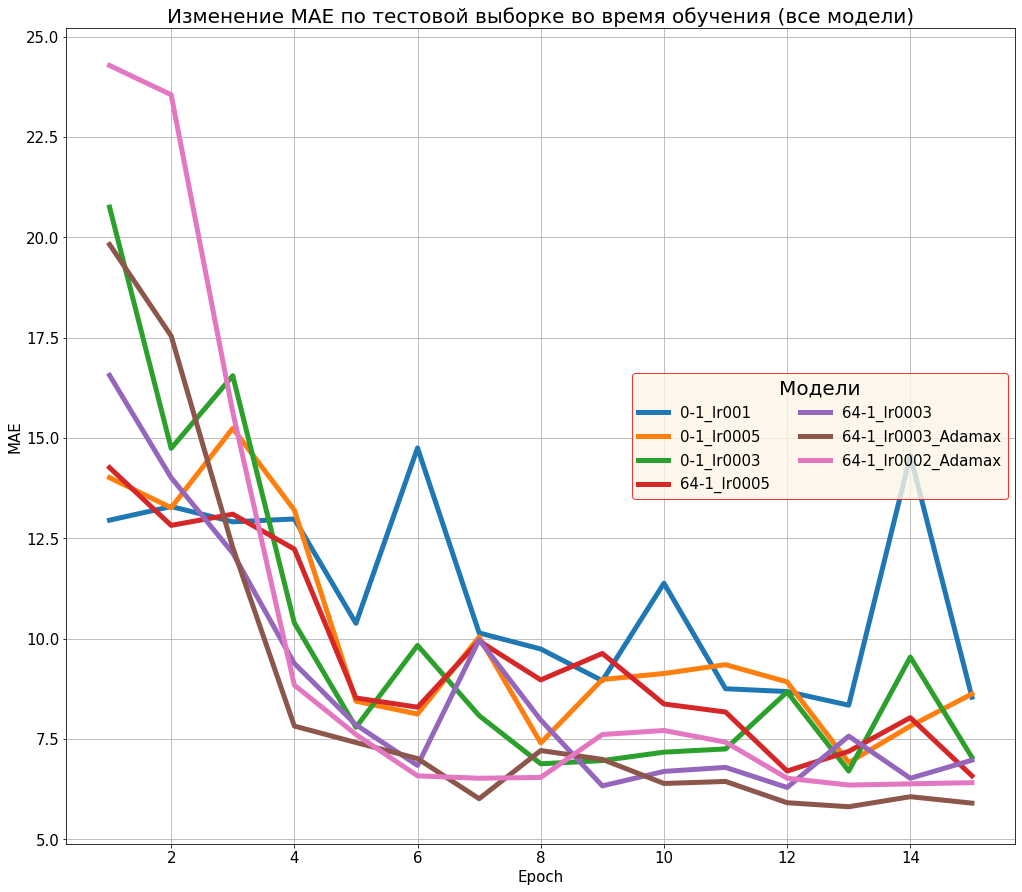

In [6]:
data_plot(df_mae, 'Изменение MAE по тестовой выборке во время обучения (все модели)')

Самой не подходящей оказалась скорость обучения 0.001. 

Для самой низкой скорости 0.0002 похоже нужно заметно больше эпох для достижения аналогичного результата, и следовательно больше вычислительных ресурсов.


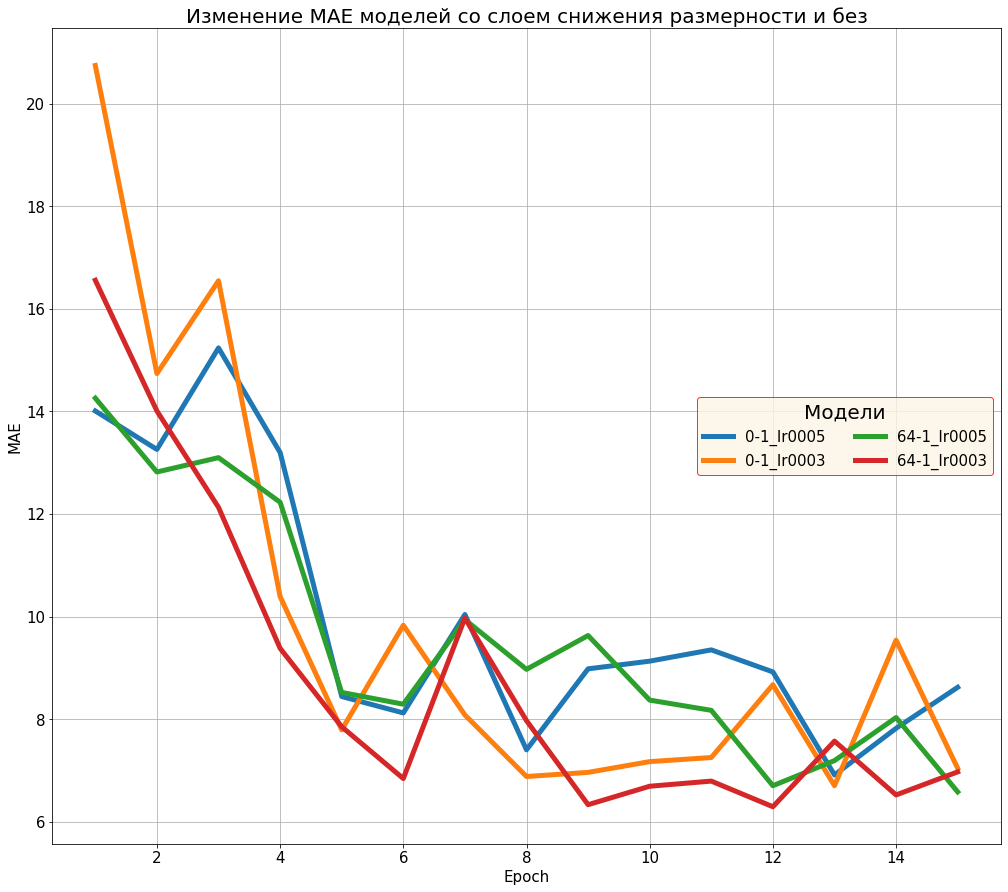

In [7]:
models_4 = [ '0-1_lr0005',   '0-1_lr0003', 
            '64-1_lr0005', '64-1_lr0003']

data_plot(df_mae[models_4] , 'Изменение MAE моделей со слоем снижения размерности и без')

При скорости обучения 0.0003 приемлемое значение МАЕ было дастигнуто на 5 эпохе.

Введение в модель дополнительного слоя снижения размерности позволило достичь более низких показаний MAE.


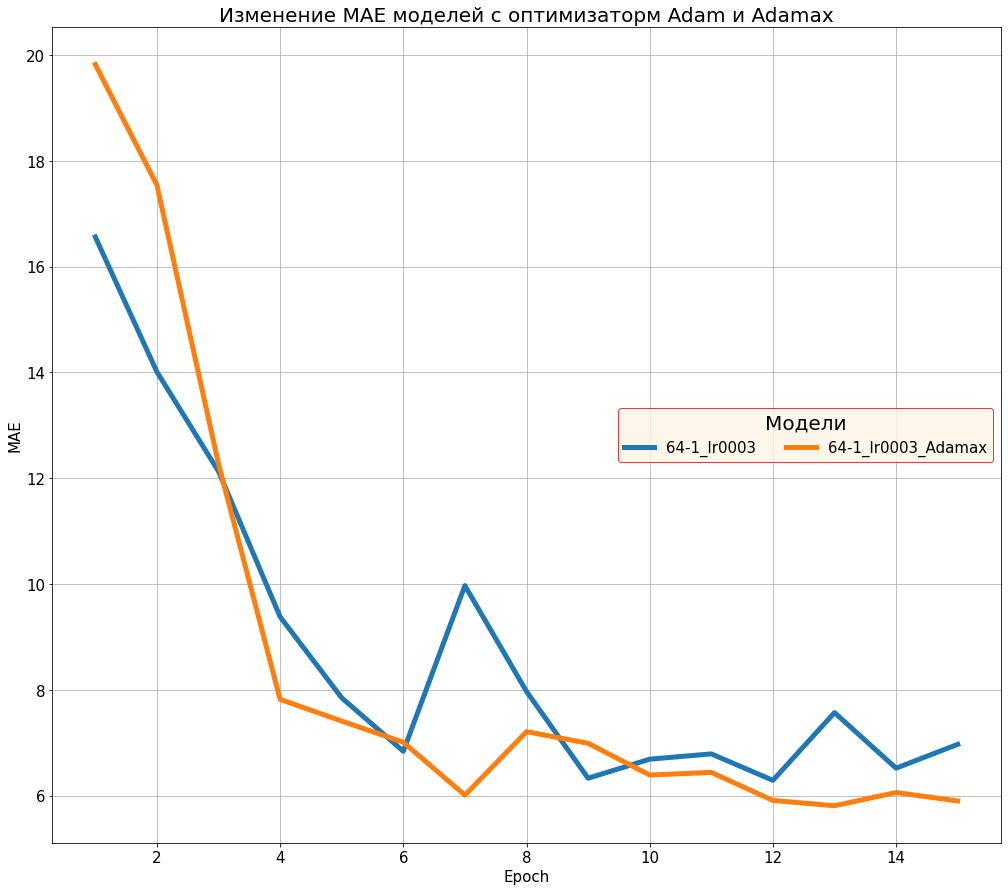

In [8]:
models_2 = [ '64-1_lr0003' 
            , '64-1_lr0003_Adamax']

data_plot(df_mae[models_2], 'Изменение MAE моделей с оптимизаторм Adam и Adamax')

Изменение оптимизатора на *Adamax* привело к меньшим скачкам MAE и позволило достичь лучших результатов при тех же параметрах

**Вывод**

Метрика МАЕ на тестовом наборе данных составила 5.90, что ниже целевого показателя 8. Таким образом, достигнуто необходимое качество модели. Опытным путём были подобраны:
   - Оптимизатор `Adamax`;
   - Параметр оптимизатора learning_rate=0.0003;
   - Количество эпох = 15
   - Количество нейронов в предпоследнем слое = 64.

##  Вывод

- Была поставлена задача создания модели, которая по фотографии определит приблизительный возраст человека.

- Сначала был произведён анализ представленного датасета. Проблем и ошибок, мешающих созданию модели по имеемым данным выявлено небыло. Были выявлены факторы, которые могли быть причиной снижения качества модели: малое количество фотографий лиц старшего возраста и наличие фотографий, на которых лицо занимает малую часть фотографии.

- Создание модели с нуля могло-бы занять большое количество времени(и не гарантировало-бы результат). Поэтому было принято решение создавать модель на основе извесных архитектур имеемых в библиотеке Keras. Выбор архитектуры ResNet50 обусловлен тем, что модели на её основе подходят для решения поставленной задачи, и при этом время решения и вычислительная нагрузка будет лежать в разумных пределах. Последние два слоя модели ResNet50 были заменены на три слоя, наиболее подходящих под задачу. 

- Созданная модель показала достаточное качество со значением **MAE = 5.90**, что ниже целевого показателя равного 8. Таким образом можно сделать вывод, что задача создания модели определения приблизительного возраста человека по фотографии решена.

**Средняя ошибка модели почти 6 лет. Что это может значить?**
- Если мы предложим модели назвать возраст ребёнка на фотографии, то она вряд ли перепутает его с пожилым человеком.
- Сложно сказать, на людях каких возрастов модель ошибается больше всего. У нас нет возможности посмотреть на предсказания в силу реализации обучения.
- В работу модели могут вносить случайность сами люди с фотографий: некоторые люди выглядят значительно старше своего возраста, другие - наоборот, более молодо.
- Модель скорее **оценивает** фотографию по тем признакам, которые ей удалось усвоить, и говорит, что "человек с такой-то внешностью тянет на такой-то возраст". Возможно, что в этом смысле модель ведёт себя подобно людям и ошибается в тех же местах, где ошибся бы человек.

**Будет ли от модели польза для бизнеса?**
- Если мы имеем ошибку в 6 лет, то рискуем не отличить взрослого от ребёнка в случае с продажей алкоголя. Паспорт всё так же придётся спрашивать.
- С рекомендацией товаров всё лучше: потребности людей не меняются кардинально раз в год, и у нас будет возможность довольно *точно определять крупные возрастные категории* - детей, подростков, молодых, зрелых, пенсионеров и изучать их потребности в автоматическом режиме. Допустим, если у нас есть предсказанный возраст человека и его чек, то мы можем совместить данные о транзакции с возрастом и сделать предположение о том, что тот или иной товар интересен аудитории.

Для дальнейшего повышения качества модели, можно попробовать применить другие известные архитектуры нейросетей, а также поработать над качеством и количеством фотографий в обучающем наборе данных.